In [30]:
!pip install --upgrade hifi-gan-bwe

In [31]:
!pip install scipy

In [32]:
!pip install resampy

In [33]:
import audioread
import numpy as np
import torch
import torchaudio
from IPython.display import Audio
from hifi_gan_bwe import BandwidthExtender
import os
import time
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy.signal import decimate, upfirdn, firwin, resample_poly, lfilter, spectrogram, freqz
from scipy.fft import fft, fftfreq
import resampy
import torchaudio

In [34]:
model = BandwidthExtender.from_pretrained("hifi-gan-bwe-10-42890e3-vctk-48kHz")

In [35]:
originalFilePath = "FullBandFiles/p232_005.wav"

In [36]:
fs, original_data = wav.read(originalFilePath)
original_data = original_data.astype(np.float32)/32767

In [37]:
new_fs = 16000
q = int(fs/new_fs)

def downsample_data2(data):
    
    downsampled_data = decimate(data, q, n=q*20, ftype='fir', zero_phase=True)
    new_downsampled_data = downsampled_data

    return new_downsampled_data

downsampled_data = downsample_data2(original_data)

In [38]:

# Function to upsample a signal
def upsample_signal(signal: np.ndarray, input_sample_rate: int, target_sample_rate: int) -> np.ndarray:
    # Convert the signal to a PyTorch tensor
    x = torch.from_numpy(signal).float()
    
    # Ensure the signal is in the correct shape (batch size, channels, samples)
    if len(x.shape) == 1:
        x = x.unsqueeze(0).unsqueeze(0)
    elif len(x.shape) == 2:
        x = x.unsqueeze(0)

    # Perform the resampling
    x_upsampled = torchaudio.functional.resample(
        x,
        orig_freq=input_sample_rate,
        new_freq=target_sample_rate,
        resampling_method="kaiser_window",
        lowpass_filter_width=16,
        rolloff=0.9,
        beta=14.769656459379492,
    )
    
    # If the original signal was 1D, squeeze the result back to 1D
    if len(signal.shape) == 1:
        x_upsampled = x_upsampled.squeeze(0).squeeze(0)
    elif len(signal.shape) == 2:
        x_upsampled = x_upsampled.squeeze(0)

    # Convert the upsampled tensor back to a NumPy array
    upsampled_signal = x_upsampled.numpy()
    
    return upsampled_signal

upsampled_signal = upsample_signal(downsampled_data, 48000, 144000)

/tmp/ipykernel_28/2465148205.py:13: UserWarning: "kaiser_window" resampling method name is being deprecated and replaced by "sinc_interp_kaiser" in the next release. The default behavior remains unchanged.
  x_upsampled = torchaudio.functional.resample(


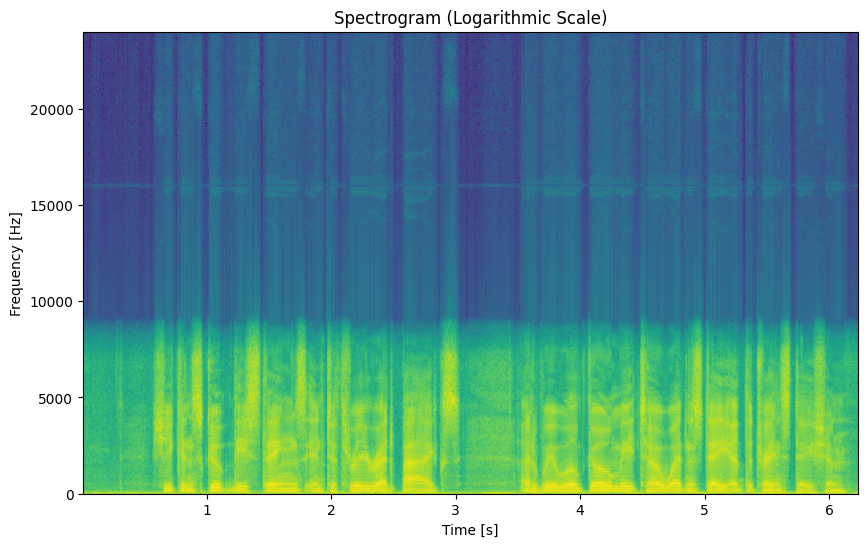

In [39]:
n = 1024

plt.figure(figsize=(10, 6))
plt.specgram(upsampled_signal, NFFT=n, Fs=fs, noverlap=int(n/2), scale = "dB")
#plt.pcolormesh(t, f, Sxx_dB, shading='gouraud')
#plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram (Logarithmic Scale)')
plt.show()

In [40]:
def run_model(downsampled_data):
    data = downsampled_data.reshape([-1, 1])
    with torch.no_grad():
        y = np.stack([model(torch.from_numpy(data), new_fs) for data in data.T]).T
        y = y.reshape(-1)
    return y

#bwe_data = run_model(downsampled_data)

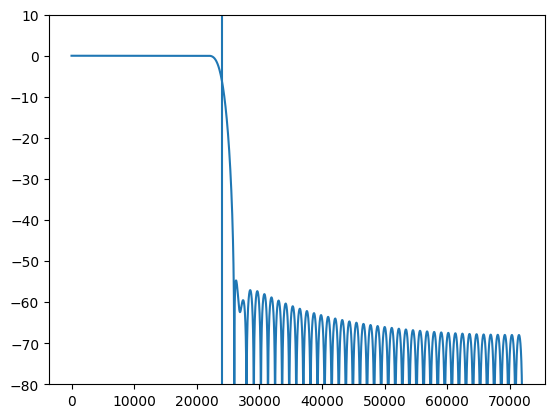

In [41]:
upsample_factor = 3
def upsample_signal1(signal):
    upsampled_signal = np.zeros(len(signal) * upsample_factor)
    upsampled_signal[::upsample_factor] = signal
    
    #Low-pass filter
    cutoff_freq = 24000
    numtaps = 128
    lpf = firwin(numtaps, cutoff_freq, fs=fs * upsample_factor, window='hamming')
    
    
    interpolated_signal = upfirdn(lpf, upsampled_signal, up=1, down=1)

    sample_rate = 144000
    w, h = freqz(lpf, worN=8000)
    w = w * sample_rate / (2 * np.pi)
    plt.plot(w, 20 * np.log10(abs(h)), label='FIR Filter Amplitude Response')
    plt.ylim(-80,10)
    plt.axvline(x=24000)
    
    return interpolated_signal

upsampled_data = upsample_signal1(original_data)

In [42]:
def upsample_signal2(signal):
    resampled_signal = resample_poly(signal, up=upsample_factor, down=1)
    return resampled_signal

In [43]:
def upsample_signal3(signal):
    # Create an upsampled array with zeros
    upsampled_signal = np.zeros(len(signal) * upsample_factor)
    upsampled_signal[::upsample_factor] = signal  # Insert the original data every 3 samples
    
    return upsampled_signal

upsampled_data3 = upsample_signal3(original_data)

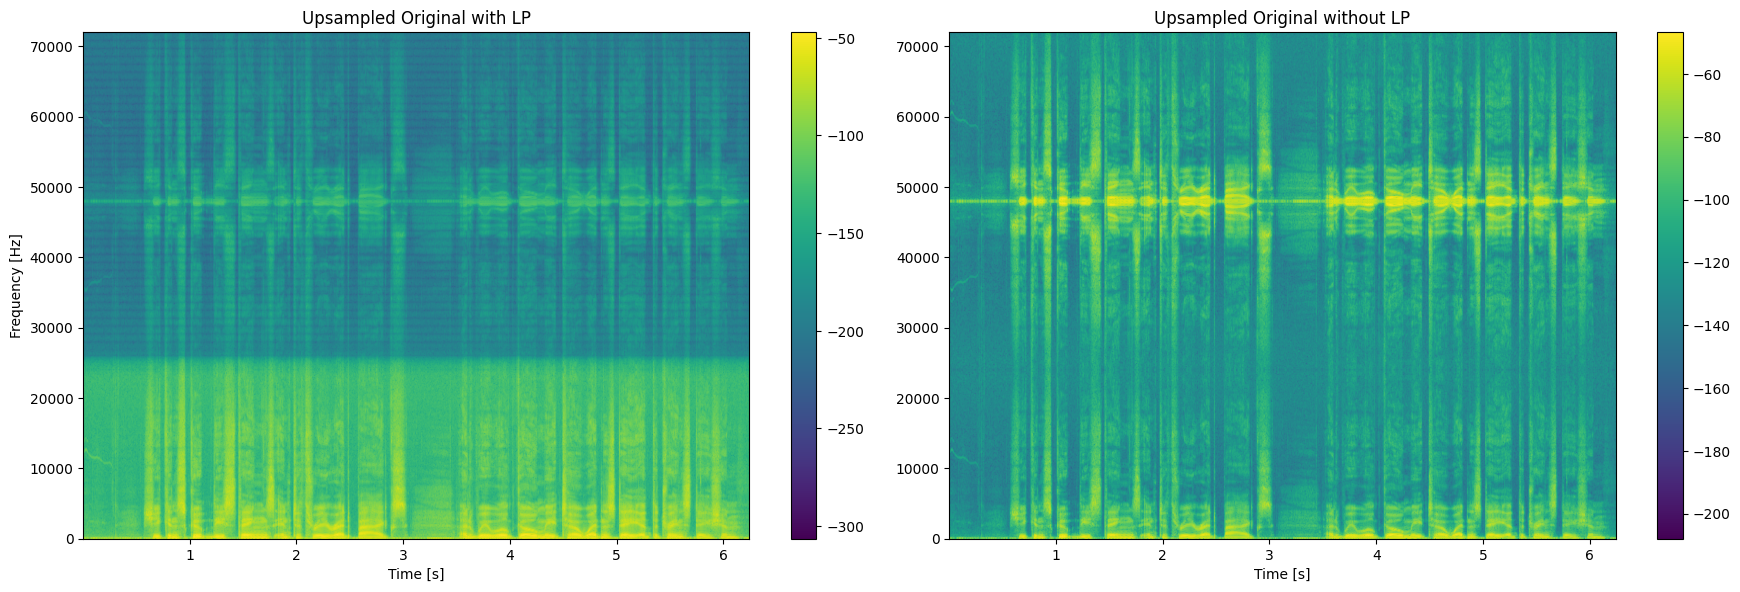

In [44]:
n = 2**10
noverlap = int(n / 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Original data spectrogram
Pxx_original, freqs, bins, im = ax1.specgram(upsampled_data, NFFT=n, Fs=fs*upsample_factor, noverlap=noverlap, scale='dB')
ax1.set_title('Upsampled Original with LP')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Frequency [Hz]')
fig.colorbar(im, ax=ax1, orientation='vertical')

# BWE data spectrogram
Pxx_bwe, freqs, bins, im = ax2.specgram(upsampled_data3, NFFT=n, Fs=fs*upsample_factor, noverlap=noverlap, scale='dB')
ax2.set_title('Upsampled Original without LP')
ax2.set_xlabel('Time [s]')
fig.colorbar(im, ax=ax2, orientation='vertical')






fig.tight_layout(pad=1.0)
plt.subplots_adjust(wspace=0.04)
fig.savefig('Results/spectrograms_w_difference', dpi=100)
plt.show()

/tmp/ipykernel_28/2960657069.py:6: UserWarning: Adding colorbar to a different Figure <Figure size 1000x600 with 2 Axes> than <Figure size 640x480 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(im, orientation='vertical')


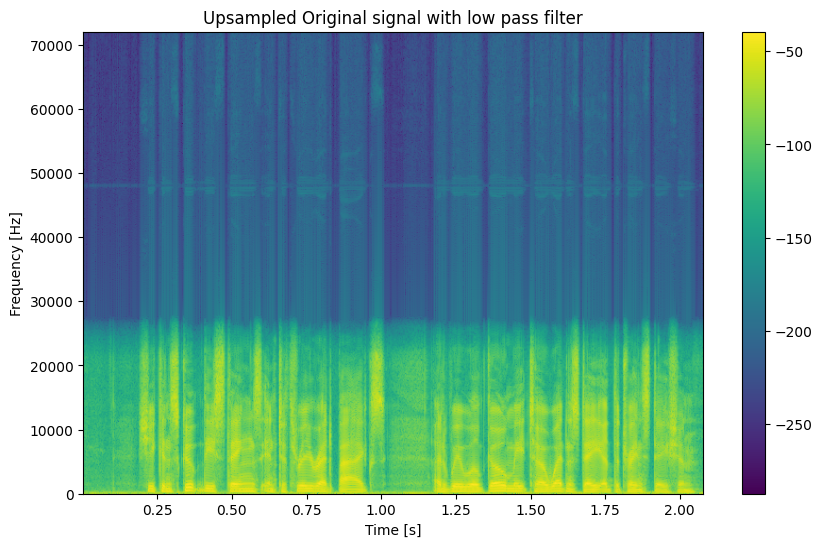

In [67]:
plt.figure(figsize=(10, 6))
Pxx_original, freqs, bins, im = plt.specgram(upsampled_signal, NFFT=n, Fs=fs*upsample_factor, noverlap=noverlap, scale='dB')
plt.title('Upsampled Original signal with low pass filter')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
fig.colorbar(im, orientation='vertical')
plt.savefig('Results/upsample_test.png', dpi=100)
plt.show()

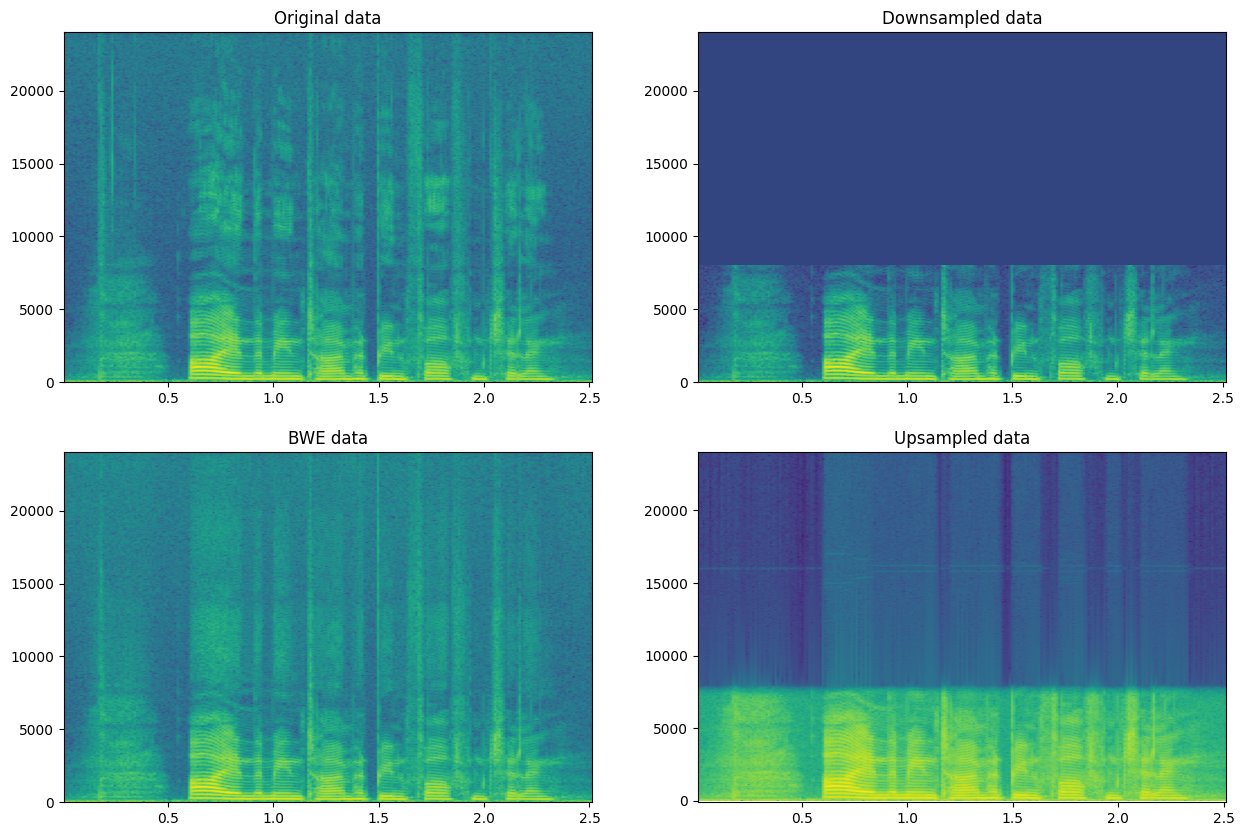

In [46]:
#####SPECTROGRAMS#####

folderpath = 'FullBandFiles'
list_of_wavs = os.listdir(folderpath)

index = 0

filename = list_of_wavs[index]
filepath = os.path.join(folderpath, filename)

fs, original_data = wav.read(filepath)
original_data = original_data.astype(np.float32)/32767

new_fs = 16000
q = int(fs/new_fs)

downsampled_data = downsample_data2(original_data)
bwe_data = run_model(downsampled_data)
upsampled_data = resampy.resample(downsampled_data, 16000, 48000)
#upsampled_data = upsample_signal(downsampled_data)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

n = 1024

ax1.specgram(original_data, NFFT=n, Fs=fs, noverlap=int(n/2), scale = "dB")
ax1.set_title('Original data')
#ax1.set_yscale('log')

ax2.specgram(downsampled_data, NFFT=int(n/3), Fs=new_fs, noverlap=int(n/6), scale = "dB")
ax2.set_title('Downsampled data')
ax2.set_facecolor((0.2, 0.27, 0.5))
ax2.set_ylim(0,24000)
#ax2.set_yticks([])

ax3.specgram(bwe_data, NFFT=n, Fs=fs, noverlap=int(n/2), scale = "dB")
ax3.set_title('BWE data')
#ax3.set_yticks([])
#fig.tight_layout(pad=1.0)

ax4.specgram(upsampled_data, NFFT=n, Fs=fs, noverlap=int(n/2), scale = "dB")
ax4.set_title('Upsampled data')
ax4.set_ylim(-100,24000)

#fig.savefig('Results/spectrograms_sample2', dpi=100)


index = 0

filename = list_of_wavs[index]
filepath = os.path.join(folderpath, filename)

fs, original_data = wav.read(filepath)
original_data = original_data.astype(np.float32)/32767

new_fs = 16000
q = int(fs/new_fs)

downsampled_data = downsample_data2(original_data)
bwe_data = run_model(downsampled_data)
upsampled_data = resampy.resample(downsampled_data, 16000, 48000)
#upsampled_data = upsample_signal(downsampled_data)plt.show()

[]

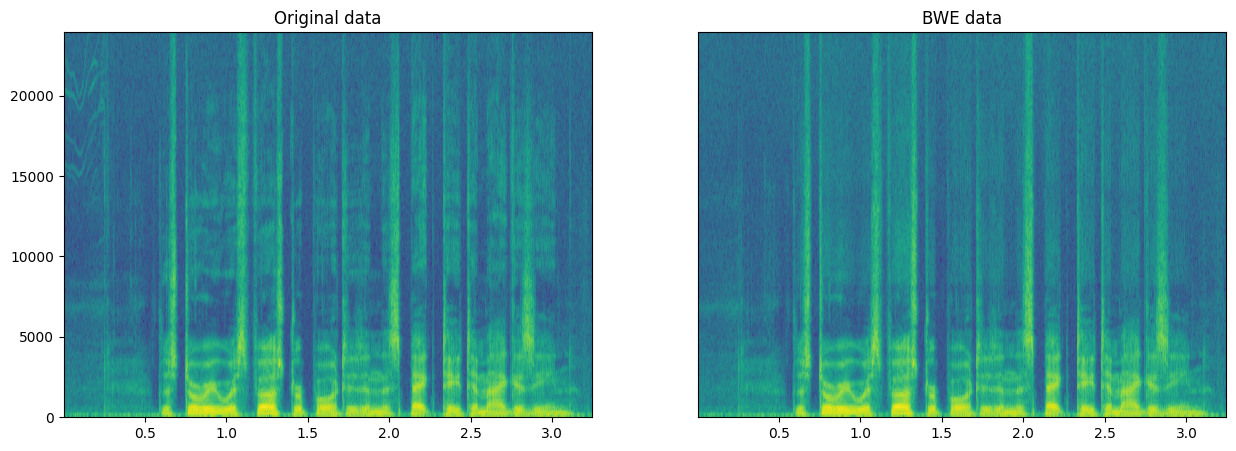

In [47]:
index = 71

filename = list_of_wavs[index]
filepath = os.path.join(folderpath, filename)

fs, original_data = wav.read(filepath)
original_data = original_data.astype(np.float32)/32767

new_fs = 16000
q = int(fs/new_fs)

downsampled_data = downsample_data2(original_data)
bwe_data = run_model(downsampled_data)*32767
fs, original_data = wav.read(filepath)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.specgram(original_data, NFFT=int(n/3), Fs=fs, noverlap=int(n/6), scale = "dB")
ax1.set_title('Original data')

ax2.specgram(bwe_data, NFFT=int(n/3), Fs=fs, noverlap=int(n/6), scale = "dB")
ax2.set_title('BWE data')

#ax2.colorbar(label='Intensity [dB]')
ax2.set_yticks([])

0.0035212215718890324


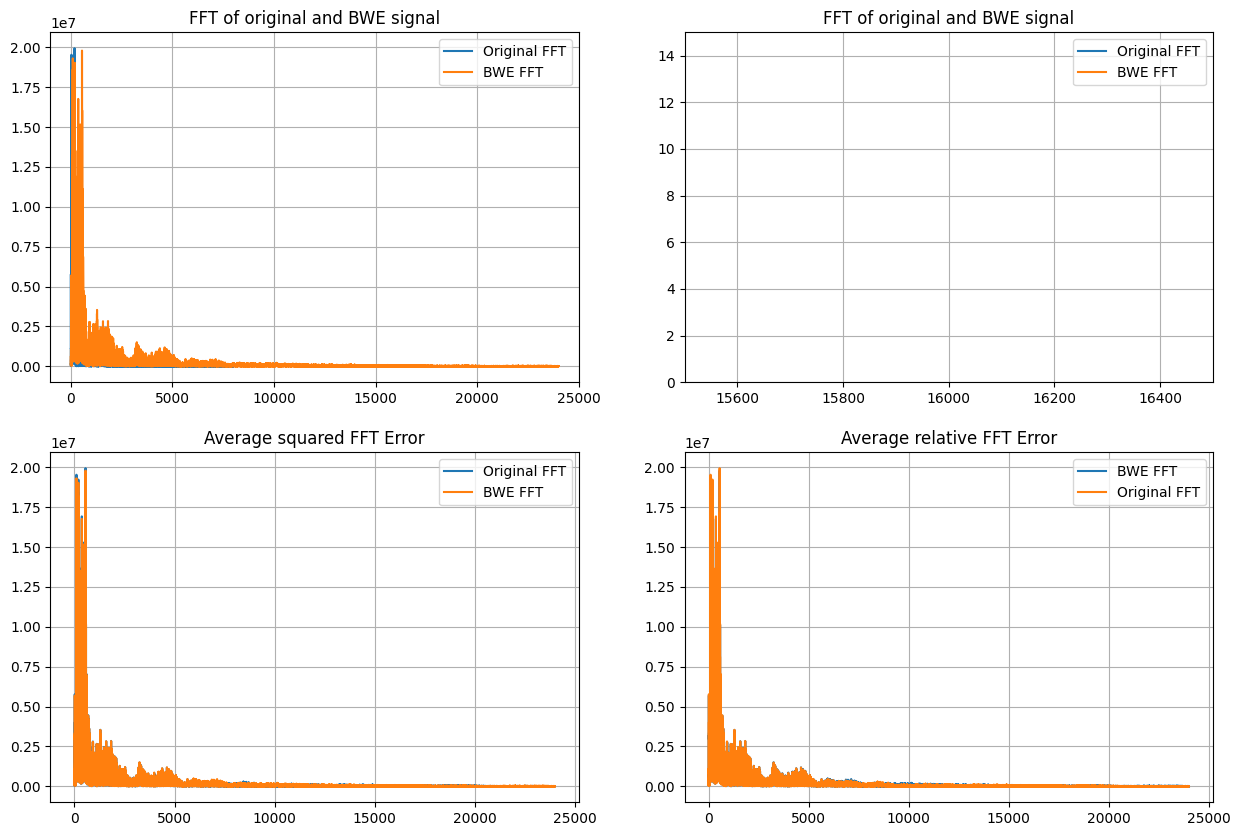

In [48]:
fft_length = 2**int(np.ceil(np.log2(len(bwe_data))))


#Create FFTs
original_fft = np.abs(np.fft.rfft(original_data, n = fft_length))
downsampled_fft = np.abs(np.fft.rfft(downsampled_data, n = fft_length))
upsampled_fft = np.abs(np.fft.rfft(upsampled_data, n = fft_length))
bwe_fft = np.abs(np.fft.rfft(bwe_data, n = fft_length))

period = 1/fs      
freq = np.fft.rfftfreq(fft_length, period)
freq1 = np.fft.rfftfreq(fft_length, 1/16000)

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

arr = [8000,25000]

ax1.plot(freq1, original_fft)
ax1.plot(freq, bwe_fft)
ax1.set_title('FFT of original and BWE signal')
ax1.legend(['Original FFT', 'BWE FFT'])
ax1.grid(True)
#ax1.set_ylim(0,20)
ax1.set_xlim(-1000,25000)

ax2.plot(freq, original_fft)
ax2.plot(freq, bwe_fft)
ax2.set_title('Average squared FFT Error')
ax2.legend(['Original FFT', 'BWE FFT'])
ax2.grid(True)
#ax2.set_ylim(-0.01,0.01)
#ax2.set_xlim(arr)

ax3.plot(freq, original_fft)
ax3.plot(freq, bwe_fft)
ax3.set_title('FFT of original and BWE signal')
ax3.legend(['Original FFT', 'BWE FFT'])
ax3.grid(True)
ax3.set_ylim(0,15)
ax3.set_xlim(15500,16500)

ax4.plot(freq, bwe_fft)
ax4.plot(freq, original_fft)
ax4.set_title('Average relative FFT Error')
ax4.legend(['BWE FFT','Original FFT'])
ax4.grid(True)
#ax4.set_ylim(0,2)
#ax4.set_xlim(7000,24000)

#fig.savefig('Results/FFTs_sample2', dpi=100)

s = int(len(upsampled_fft)/24000)

print(np.mean(upsampled_fft[s*9000:]))

plt.show()

In [49]:
def find_fft_length(folderpath):
    max_length = 0
    wav_files = os.listdir(folderpath)
    for filename in wav_files:
        filepath = os.path.join(folderpath, filename)
        if filename[-4:].lower() != '.wav':
            continue
        sample_rate, data = wav.read(filepath)
        max_length = max(max_length, len(data))
    return 2**int(np.ceil(np.log2(max_length))), max_length+1

def pad_to_length(signal, length):
    padded_signal = np.zeros(length)
    padded_signal[:len(signal)] = signal
    return padded_signal

files = os.listdir('FullBandFiles')
i=0
j=0
for filename in files:
    j+=1
    if filename[-4:].lower() == '.wav':
        i+=1

print(i,j)

824 825


In [50]:
folderpath = 'FullBandFiles'
list_of_wavs = os.listdir(folderpath)
fs, original_data = wav.read(originalFilePath)
#fft_length =  int(len(original_data)/2)
#print(fft_length)
#fft_length = find_fft_length(folderpath) #524288
fft_length, data_length = find_fft_length(folderpath)

fft_arr_length = int(fft_length/2+1)
sum_squared_error = np.zeros(fft_arr_length)
sum_relative_error = np.zeros(fft_arr_length)
sum_original_fft = np.zeros(fft_arr_length)
sum_bwe_fft = np.zeros(fft_arr_length)

In [14]:
start_time = time.time()

fft_dict = {} #To store FFT data

for index, filename in enumerate(list_of_wavs):
    
    #Fetch original data and convert to float32
    filepath = os.path.join(folderpath, filename)
    if filename[-4:].lower() != '.wav':
        continue
    fs, original_data = wav.read(filepath)
    original_data = original_data.astype(np.float32)/32767
    

    #Downsample data and prep for model
    downsampled_data = downsample_data2(original_data)
    

    #Run model
    bwe_data = run_model(downsampled_data)

    original_data = pad_to_length(original_data, data_length)
    bwe_data = pad_to_length(bwe_data, data_length)
    

    #Create FFTs
    original_fft = np.abs(np.fft.rfft(original_data, n = fft_length))
    bwe_fft = np.abs(np.fft.rfft(bwe_data, n = fft_length))
    
    #Save to FFTs dictionary
    fft_dict[f'arr1_{index}'] = original_fft
    fft_dict[f'arr2_{index}'] = bwe_fft
    
    #Timetracker
    temp_stop = time.time()
    temp_elapsed = int(temp_stop - start_time)
    if index%25==0:
        print(f'Iteration {index + 1} out of {len(list_of_wavs)}. Elapsed time: ' +
      (f'{temp_elapsed // 60} minutes and ' if temp_elapsed >= 60 else '') +
      f'{temp_elapsed % 60} seconds')


#Save FFT dictionary to file
fft_arrays = 'fft_arrayz.npz'
np.savez(fft_arrays, **fft_dict)

#Print running time
stop_time = time.time()
elapsed_time = int(stop_time - start_time)

print(f'Total running time for {len(list_of_wavs)} iterations: ' + (f'{elapsed_time // 60} minutes and ' if elapsed_time >= 60 else '') +
      f'{temp_elapsed % 60} seconds')

#compare_array_metadata(original_fft, bwe_fft)

Iteration 1 out of 825. Elapsed time: 2 seconds
Iteration 26 out of 825. Elapsed time: 1 minutes and 8 seconds
Iteration 51 out of 825. Elapsed time: 2 minutes and 11 seconds
Iteration 76 out of 825. Elapsed time: 3 minutes and 21 seconds
Iteration 101 out of 825. Elapsed time: 4 minutes and 35 seconds
Iteration 126 out of 825. Elapsed time: 5 minutes and 45 seconds
Iteration 151 out of 825. Elapsed time: 6 minutes and 59 seconds
Iteration 176 out of 825. Elapsed time: 8 minutes and 7 seconds
Iteration 201 out of 825. Elapsed time: 9 minutes and 17 seconds
Iteration 226 out of 825. Elapsed time: 10 minutes and 25 seconds
Iteration 251 out of 825. Elapsed time: 11 minutes and 25 seconds
Iteration 276 out of 825. Elapsed time: 12 minutes and 26 seconds
Iteration 301 out of 825. Elapsed time: 13 minutes and 27 seconds
Iteration 326 out of 825. Elapsed time: 14 minutes and 38 seconds
Iteration 351 out of 825. Elapsed time: 15 minutes and 45 seconds
Iteration 376 out of 825. Elapsed time: 1

In [51]:
fft_errors = []
fft_arrays = 'fft_arrayz.npz'

with np.load(fft_arrays) as data:
    i = 0
    while f'arr1_{i}' in data:
        original_fft = data[f'arr1_{i}']
        bwe_fft = data[f'arr2_{i}']
        squared_fft_error = (original_fft - bwe_fft)
        relative_fft_error = abs(original_fft - bwe_fft)/original_fft
        fft_errors.append(original_fft - bwe_fft)
        
        sum_squared_error += squared_fft_error
        sum_relative_error += relative_fft_error
        sum_original_fft += original_fft
        sum_bwe_fft += bwe_fft
        i += 1
num_files = i

3.123779542359876
7.367461292931326


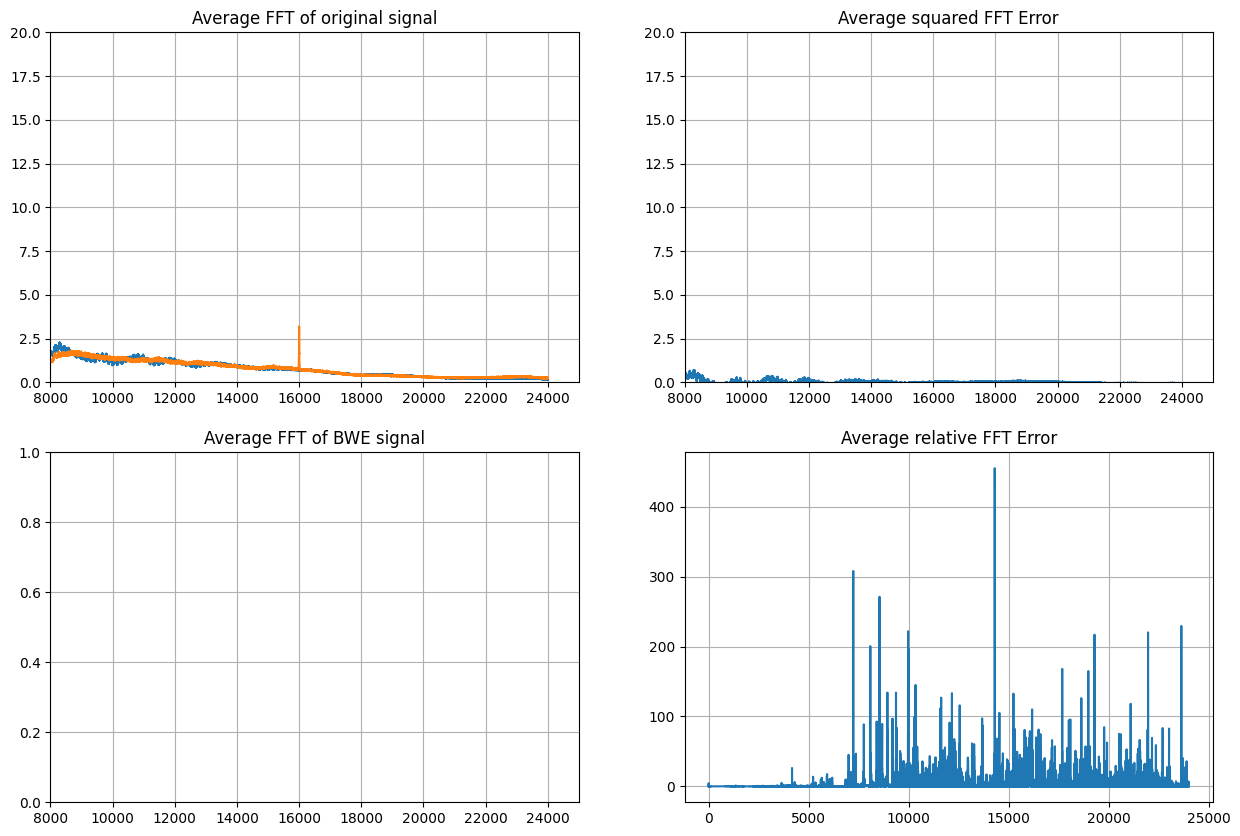

In [53]:
#Averaging FFTs
avg_squared_error = sum_squared_error/num_files
avg_relative_error = sum_relative_error/num_files
avg_original_fft = sum_original_fft/num_files
avg_bwe_fft = sum_bwe_fft/num_files



#Calculate std
fft_errors = np.array(fft_errors)
fft_error_std = np.std(fft_errors, axis=0)


period = 1/fs      
freq = np.fft.rfftfreq(fft_length, period)

def plot_ffts():
        
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    arr = [8000,25000]
    
    ax1.plot(freq, avg_original_fft)
    ax1.set_title('Average FFT of original signal')
    ax1.grid(True)
    ax1.set_ylim(0,20)
    ax1.set_xlim(arr)
    
    ax2.plot(freq, avg_squared_error)
    ax2.set_title('Average squared FFT Error')
    ax2.grid(True)
    ax2.set_ylim(0,20)
    ax2.set_xlim(arr)
    
    ax1.plot(freq, avg_bwe_fft)
    ax3.set_title('Average FFT of BWE signal')
    ax3.grid(True)
    #ax3.set_ylim(0,20)
    ax3.set_xlim(arr)
   
    ax4.plot(freq, relative_fft_error)
    ax4.set_title('Average relative FFT Error')
    ax4.grid(True)
    #ax4.set_ylim(0,2)
    #ax4.set_xlim(7000,24000)
    

    #fig.savefig('Results/original_BWE+error.png', dpi=100)

def plot_and_save():
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(freq, avg_original_fft)
    #ax1.set_title("Average FFT of BWE signal")
    
    ax2.plot(freq, avg_original_fft)
    ax2.set_ylim(0,10)
    
    #fig2.suptitle("Average FFT of original signal", fontsize=20)
    fig2.savefig('Results/original_BWE+error.png', dpi=100)



#plot_and_save()

plot_ffts()


#plt.plot(freq, fft_error_std)
#plt.title('Standard deviation for the FFT error')
#plt.grid(True)
#plt.ylim(0,80)
#plt.savefig('FFT_error_std.png', dpi=100)

print(avg_original_fft[0])
print(avg_bwe_fft[0])


plt.show()

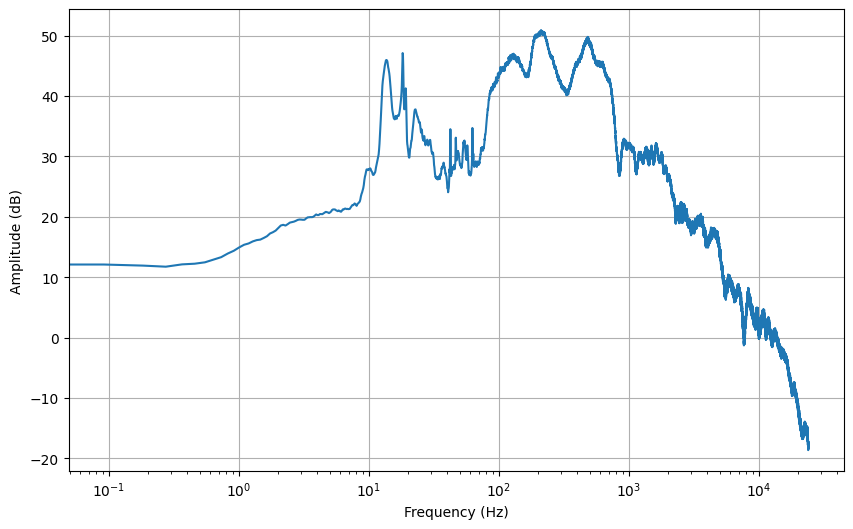

In [54]:
plt.figure(figsize= (10,6)) 
plt.plot(freq, 10*np.log(avg_original_fft))



plt.xscale('log')
plt.xlabel('Frequency (Hz)')

plt.ylabel('Amplitude (dB)')
plt.grid()
plt.show()

In [55]:
from scipy.signal import firwin, freqz
from scipy.fft import fft, fftfreq

def amp_response_coeff():
    sample_rate = 48000
    cutoff_freq_hz = 8000  # Cutoff frequency in Hz

    # Design an FIR lowpass filter
    numtaps = 64  # Number of taps in the FIR filter
    cutoff_freq = cutoff_freq_hz / (sample_rate / 2)  # Normalize the cutoff frequency
    b = firwin(numtaps, cutoff=cutoff_freq)
    
    # Compute the frequency response of the filter
    w, h = freqz(b, worN=8000)
    w = w * sample_rate / (2 * np.pi)
    
    return w, h
    
    plt.plot(w, 20 * np.log10(abs(h)), label='FIR Filter Amplitude Response')

1.3932233131932878


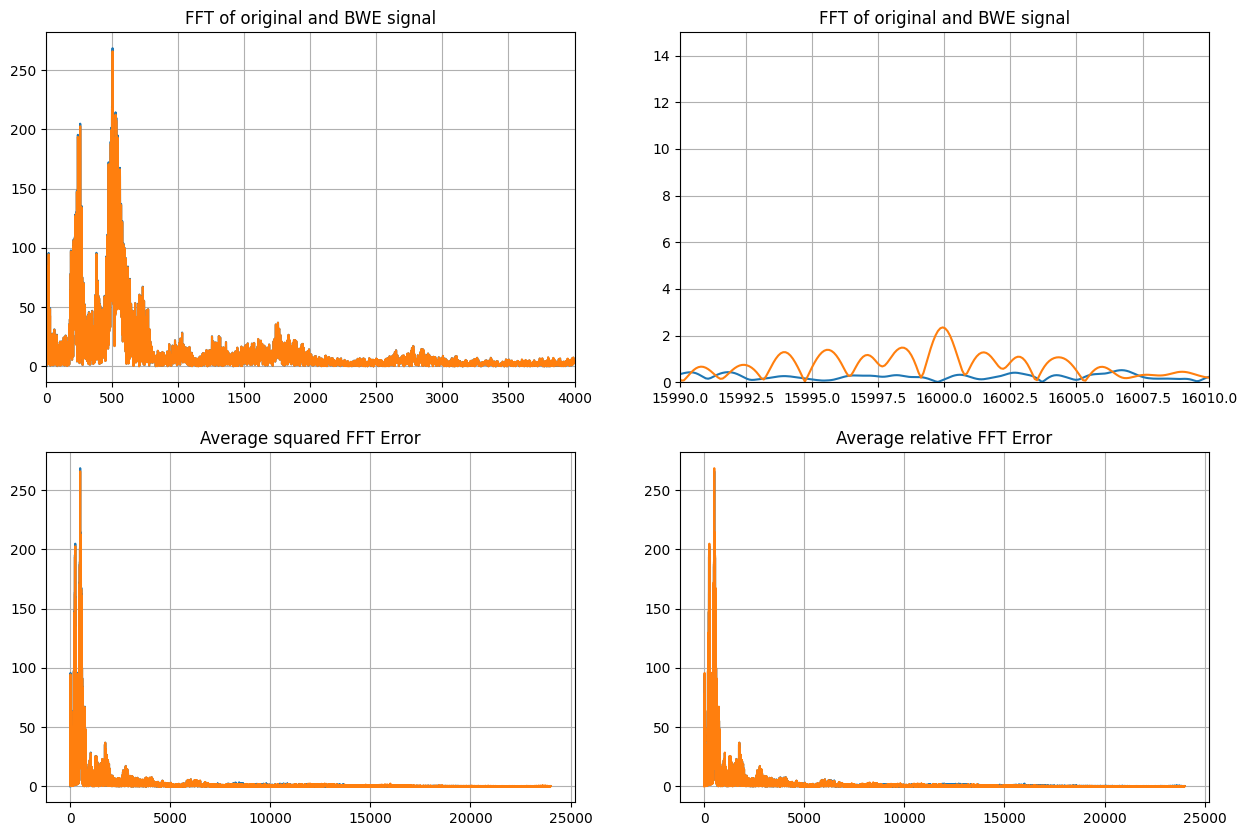

In [56]:
fft_arrays = 'fft_arrayz.npz'

def plot_some_ffts(i):
    with np.load(fft_arrays) as data:
    
        original_fft = data[f'arr1_{i}']
        bwe_fft = data[f'arr2_{i}']
        squared_fft_error = (original_fft - bwe_fft)**2
        relative_fft_error = abs(original_fft - bwe_fft)/original_fft
    
    
    period = 1/fs      
    freq = np.fft.rfftfreq(fft_length, period)
    
    fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    arr = [8000,25000]
    
    ax1.plot(freq, original_fft)
    ax1.plot(freq, bwe_fft)
    ax1.set_title('FFT of original and BWE signal')
    ax1.grid(True)
    #ax1.set_ylim(0,20)
    ax1.set_xlim(0,4000)
    
    ax2.plot(freq, original_fft)
    ax2.plot(freq, bwe_fft)
    ax2.set_title('Average squared FFT Error')
    ax2.grid(True)
    #ax2.set_ylim(0,20)
    #ax2.set_xlim(arr)
    
    ax3.plot(freq, original_fft)
    ax3.plot(freq, bwe_fft)
    ax3.set_title('FFT of original and BWE signal')
    ax3.grid(True)
    ax3.set_ylim(0,15)
    ax3.set_xlim(15990,16010)
    
    ax4.plot(freq, bwe_fft)
    ax4.plot(freq, original_fft)
    ax4.set_title('Average relative FFT Error')
    ax4.grid(True)
    #ax4.set_ylim(0,2)
    #ax4.set_xlim(7000,24000)
    
    s = int(len(bwe_fft)/24000)
    
    print(np.max(bwe_fft[s*15500:s*16500]))

i = 50
plot_some_ffts(i)
plt.show()

In [57]:
folderpath = 'FullBandFiles'
folderlist = os.listdir(folderpath)

for count, filename in enumerate(folderlist):
    filepath = os.path.join(folderpath, filename)
    
    #print(count, filepath)


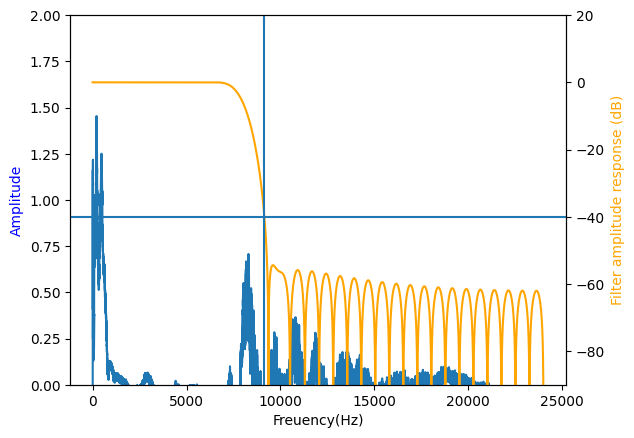

<Figure size 640x480 with 0 Axes>

In [65]:
      
w, h = amp_response_coeff()

fig, ax1 = plt.subplots()

# Plot the first set of data
ax1.plot(freq, avg_squared_error)
ax1.set_xlabel('Freuency(Hz)')
ax1.set_ylabel('Amplitude', color='b')
ax1.set_ylim(0,2)
#ax1.axvline(x=8000, color='r')

# Create a twin Axes sharing the x-axis
ax2 = ax1.twinx()
ax2.plot(w, 20 * np.log10(abs(h)), color='orange')
ax2.set_ylabel('Filter amplitude response (dB)', color='orange')
ax2.set_ylim(-90, 20)
ax2.axhline(y=-40)
ax2.axvline(x=9100)

# Show the plot
plt.show()
plt.savefig('FFT_error_and_filter.png', dpi=100)